In [1]:
import tensorflow as tf
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:

class Network:
    """
    Build a physics informed neural network (PINN) model for equation.
    """

    @classmethod
    def build(cls, num_inputs=2, layers=[32, 16, 32], activation='tanh', num_outputs=1):
        """
        Build a PINN model for equation with input shape (t, x) and output shape u(t, x).

        Args:
            num_inputs: number of input variables. Default is 2 for (t, x).
            layers: number of hidden layers.
            activation: activation function in hidden layers.
            num_outpus: number of output variables. Default is 1 for u(t, x).

        Returns:
            keras network model
        """

        # input layer
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        # hidden layers
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation,
                kernel_initializer='he_normal')(x)
        # output layer
        outputs = tf.keras.layers.Dense(num_outputs,
            kernel_initializer='he_normal')(x)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [3]:
class GradientLayer(tf.keras.layers.Layer):
    """
    Custom layer to compute 1st and 2nd derivatives for equation.

    Attributes:
        model: keras network model.
    """

    def __init__(self, model, **kwargs):
        """
        Args:
            model: keras network model.
        """

        self.model = model
        super().__init__(**kwargs)

    def call(self, x):
        """
        Computing 1st and 2nd derivatives for equation.

        Args:
            x: input variable.

        Returns:
            model output, 1st and 2nd derivatives.
        """

        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                u = self.model(x)
            du_dtx = gg.batch_jacobian(u, x)
            du_dt = du_dtx[..., 0]
            du_dx = du_dtx[..., 1]
        d2u_dx2 = g.batch_jacobian(du_dx, x)[..., 1]
        return u, du_dt, du_dx, d2u_dx2

In [4]:
class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.

    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10.0 for extremely high accuracy.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: log metrics
        progbar: progress bar
    """

    def __init__(self, model, x_train, y_train, factr=1e7, m=50, maxls=50, maxiter=5000):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        self.losses = []  # Initialize list to store loss values
        self.iterations = []  # Initialize list to store iteration numbers
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.

        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        """
        Evaluate loss and gradients for weights as tf.Tensor.

        Args:
            x: input data.

        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.

        Args:
            weights: flatten weights.

        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.

        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.losses.append(loss)  # Store the loss value
        self.iterations.append(len(self.losses))  # Store the iteration number
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
            callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

In [5]:
class PINN:
    """
    Build a physics informed neural network (PINN) model for equation.

    Attributes:
        network: keras network model with input (t, x) and output u(t, x).
        nu: kinematic viscosity.
        grads: gradient layer.
    """

    def __init__(self, network, nu):
        """
        Args:
            network: keras network model with input (t, x) and output u(t, x).
            nu: kinematic viscosity.
        """

        self.network = network
        self.nu = nu
        self.grads = GradientLayer(self.network)

    def build(self):
        """
        Build a PINN model for equation.

        Returns:
            PINN model for the projectile motion with
                input: [ (t, x) relative to equation,
                         (t=0, x) relative to initial condition,
                         (t, x=bounds) relative to boundary condition ],
                output: [ u(t,x) relative to equation (must be zero),
                          u(t=0, x) relative to initial condition,
                          u(t, x=bounds) relative to boundary condition ]
        """

        # equation input: (t, x)
        tx_eqn = tf.keras.layers.Input(shape=(2,))
        # initial condition input: (t=0, x)
        tx_ini = tf.keras.layers.Input(shape=(2,))
        # boundary condition input: (t, x=-1) or (t, x=+1)
        tx_bnd = tf.keras.layers.Input(shape=(2,))

        # compute gradients
        u, du_dt, du_dx, d2u_dx2 = self.grads(tx_eqn)

        # equation output being zero
        #u_eqn = du_dt + self.nu*du_dx #- self.nu*d2u_dx2
        u_eqn = du_dt - self.nu*d2u_dx2
        # initial condition output
        u_ini = self.network(tx_ini)
        # boundary condition output
        u_bnd = self.network(tx_bnd)

        # build the PINN model for equation
        return tf.keras.models.Model(
            inputs=[tx_eqn, tx_ini, tx_bnd], outputs=[u_eqn, u_ini, u_bnd])

In [6]:
# number of training samples
num_train_samples = 10000
# number of test samples
num_test_samples = 1000
# kinematic viscosity
nu = 0.05

# build a core network model
network = Network.build()
network.summary()
# build a PINN model
pinn = PINN(network, nu).build()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1201 (4.69 KB)
Trainable params: 1201 (4.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# create training input
tx_eqn = np.random.rand(num_train_samples, 2)          # t_eqn =  0 ~ +1
tx_eqn[..., 1] = 2 * tx_eqn[..., 1] - 1                # x_eqn = -1 ~ +1
tx_ini = 2 * np.random.rand(num_train_samples, 2) - 1  # x_ini = -1 ~ +1
tx_ini[..., 0] = 0                                     # t_ini =  0
tx_bnd = np.random.rand(num_train_samples, 2)          # t_bnd =  0 ~ +1
tx_bnd[..., 1] = 2 * np.round(tx_bnd[..., 1]) - 1      # x_bnd = -1 or +1
# create training output
u_eqn = np.zeros((num_train_samples, 1))               # u_eqn = 0
u_ini = np.exp(-20*np.pi * (tx_ini[..., 1, np.newaxis])**2)    # u_ini = -sin(pi*x_ini)
u_bnd = np.zeros((num_train_samples, 1))               # u_bnd = 0

In [8]:
# train the model using L-BFGS-B algorithm
x_train = [tx_eqn, tx_ini, tx_bnd]
y_train = [ u_eqn,  u_ini,  u_bnd]
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=5000)


5000/5000 [==============================] - 232s 46ms/step


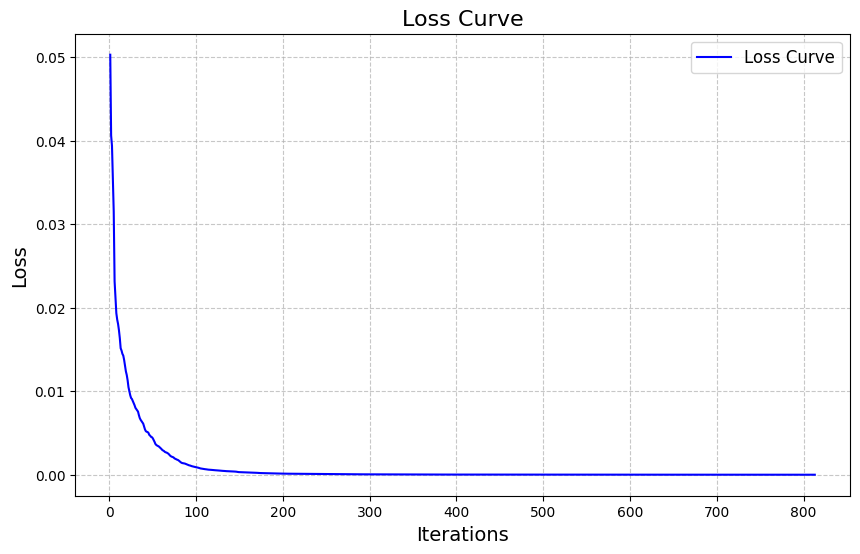

In [9]:
iterations = lbfgs.iterations
losses = lbfgs.losses

# plot evolution of loss function during the optimization
plt.figure(figsize=(10, 6), dpi = 100)
plt.plot(iterations, losses, color='blue', label='Loss Curve')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss Curve', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

In [10]:
# predict u(t,x) distribution
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)

1000/1000 [==============================] - 11s 11ms/step


1/1 [==============================] - 0s 155ms/step


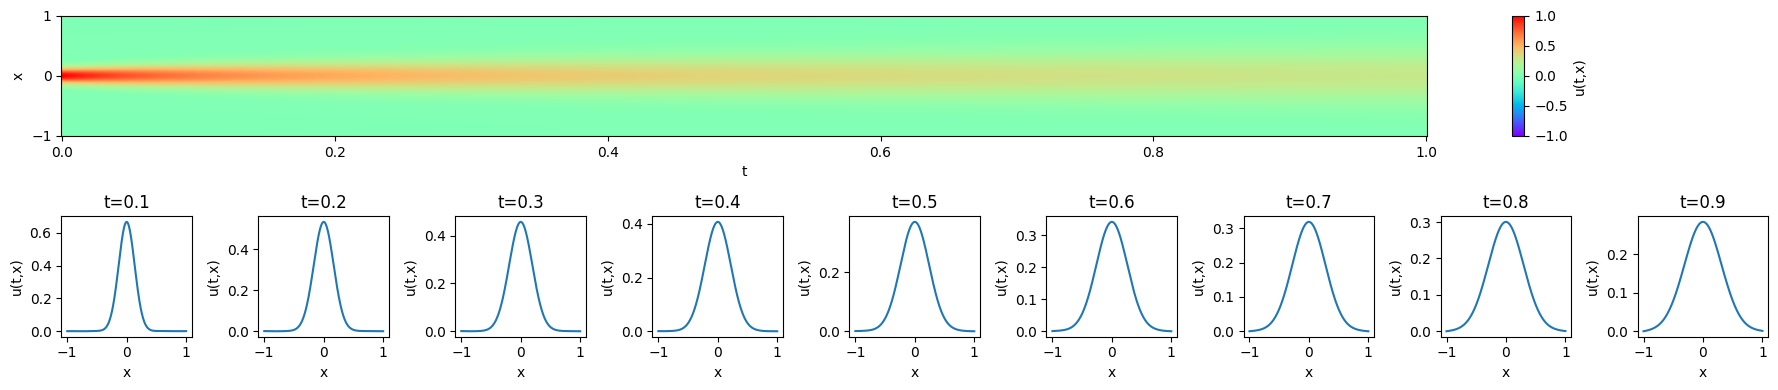

In [11]:
# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(18,4))
gs = GridSpec(2, 9)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()